In [543]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [544]:
def sharpen_image(img):
    kernel = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0],
    ])
    return cv2.filter2D(img, -1, kernel)

In [545]:
# file = "data/some_top.png"
file = "data/people_top.png"
file = "data/lots.png"
img = cv2.imread(file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sharp = sharpen_image(img)
bw = cv2.cvtColor(sharp, cv2.COLOR_RGB2GRAY)

(-0.5, 209.5, 369.5, -0.5)

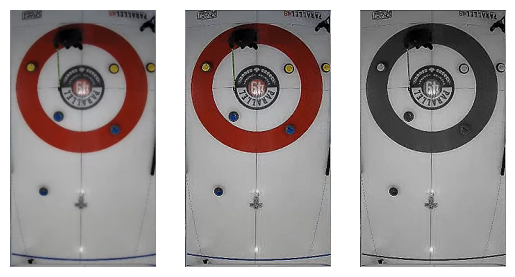

In [546]:
plt.subplot(131)
plt.imshow(img); plt.axis("off")

plt.subplot(132)
sharp = sharpen_image(img)
plt.imshow(sharp); plt.axis("off")

plt.subplot(133)
plt.imshow(bw, cmap = "gray"); plt.axis("off")

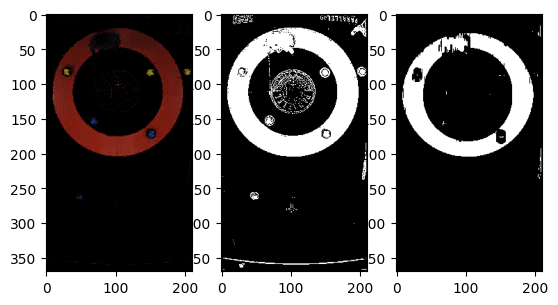

In [547]:
sharp_hsv = cv2.cvtColor(sharp, cv2.COLOR_RGB2HSV)

lower = np.array([0,0,30], dtype=np.uint8)
upper = np.array([255,130,255], dtype=np.uint8)

mask = cv2.inRange(sharp_hsv, lower, upper)
non_white = cv2.bitwise_and(sharp_hsv, sharp_hsv, mask = np.invert(mask))

plt.subplot(131)
plt.imshow(cv2.cvtColor(non_white, cv2.COLOR_HSV2RGB))

plt.subplot(132)
mask = np.invert(mask)
plt.imshow(mask, cmap = "gray")

eroded = mask.copy()
for i in range(8):
    eroded = cv2.erode(
        eroded,
        (100, 100),
        -1
    )

plt.subplot(133)
plt.imshow(eroded, cmap = "gray")


(-0.5, 209.5, 369.5, -0.5)

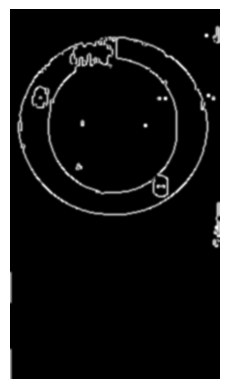

In [548]:
canny = cv2.Canny(eroded, 100, 200)
canny = cv2.GaussianBlur(canny, ksize = (5,5), sigmaX = 1)
plt.imshow(canny, cmap = "gray"); plt.axis("off")

[102 111  93]
[ 86 123  76]
[122 117  75]
[104 133 103]
[118  97  66]
[86 93 63]


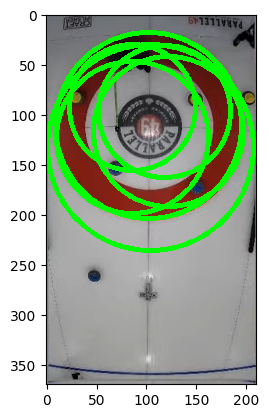

In [549]:
circles = cv2.HoughCircles(canny,cv2.HOUGH_GRADIENT,1,20,
                            param1=70,param2=40,minRadius=25)

circles = np.atleast_2d(np.squeeze(circles).astype(np.int64))
out = img.copy()
for circle in circles:
    print(circle)
    cv2.circle(
        out,
        circle[:2],
        radius= circle[-1],
        color = (0, 255, 0),
        thickness = 4
    )
plt.imshow(out)

(-0.5, 209.5, 369.5, -0.5)

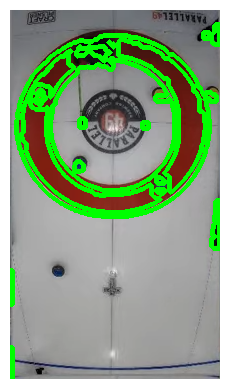

In [550]:
color_canny = np.dstack([canny for _ in range(3)])

contours, _ = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(cv2.drawContours(img.copy(), contours, -1, (0,255,0), 3)); plt.axis('off')

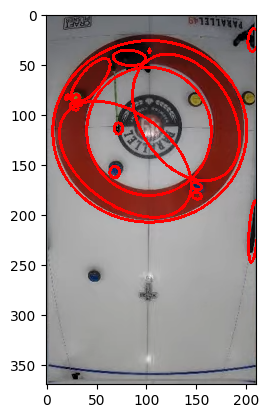

In [551]:
ellipse_img = img.copy()

axes = np.empty((len(contours), 2))
centers = np.empty_like(axes)

for n, contour in enumerate(contours):

    if len(contour) > 5:
        ellipse = cv2.fitEllipse(contour)
        centers[n], axes[n], _ = ellipse
        cv2.ellipse(ellipse_img, ellipse, (255, 0, 0), 2)
plt.imshow(ellipse_img)

In [552]:
circle_img = img.copy()

mask = np.all(axes > 1, axis = 1)
axes = axes[mask]
centers = centers[mask]
ratio = np.max(axes, axis = 1) / np.min(axes, axis = 1)

mask = ratio < 1.2
axes = axes[mask]
centers = centers[mask].astype(np.int32)

diameters = axes.mean(axis = 1)
mask = np.logical_and(diameters > 70, diameters < 550)

centers = centers[mask]
diameters = diameters[mask]
print(axes)

[[181.63665771 194.2154541 ]
 [124.50241852 128.11062622]
 [  9.89333439  11.61911201]]


Center: [103 116], Diam: 187.92605590820312
Center: [102 116], Diam: 126.30652236938477


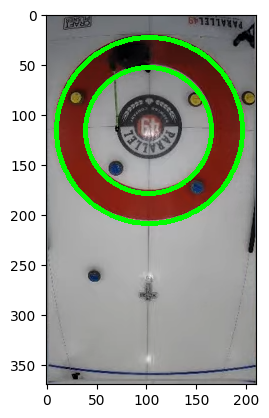

In [553]:
for diam, center in zip(diameters, centers):
    print(f"Center: {center}, Diam: {diam}")
    cv2.circle(
        circle_img,
        center,
        radius= int(diam / 2),
        color = (0, 255, 0),
        thickness = 4
    )

plt.imshow(circle_img)

In [554]:
std = centers.std(axis = 0)
means = centers.mean(axis = 0)
print(centers)

if np.any(std > 10):

    print(f"Std range filtering")
    std_range = std * np.array([
        [-0.75],
        [ 0.75]
    ]) + means
    print(std_range)

    lower_bound = np.all(centers > std_range[0], axis = 1)
    upper_bound = np.all(centers < std_range[1], axis = 1)
    mask = np.logical_and(lower_bound, upper_bound)

    centers = centers[mask]
    diameters = diameters[mask]

print(centers)
# print(means + std_range)

[[103 116]
 [102 116]]
[[103 116]
 [102 116]]


In [555]:
means

array([102.5, 116. ])

Center: [103 116], Diam: 187.92605590820312
Center: [102 116], Diam: 126.30652236938477


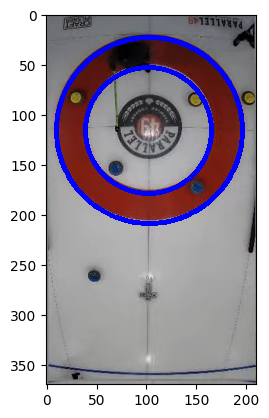

In [556]:
for diam, center in zip(diameters, centers):
    print(f"Center: {center}, Diam: {diam}")
    cv2.circle(
        circle_img,
        center,
        radius=int(diam / 2),
        color=(0, 0, 255),
        thickness=4
    )
plt.imshow(circle_img)

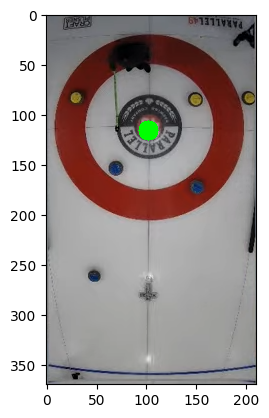

In [557]:
estimated_center = centers.mean(axis = 0).astype(np.int64)

center_img = img.copy()
cv2.circle(center_img, estimated_center, radius = 10, color = (0, 255, 0), thickness = -1)
plt.imshow(center_img)